# Rossby wave Model with 5 modes
## This jupyter notebook test inverse problem with swath samples

#### First we calculate the Brunt-Vaisla frequency squared with a sample dataset.

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
state_ds = xr.open_dataset('../../Rossby_wave_test_case/MARA_RUN2_SWOT_state_2015-01-06.nc')
#state_ds #.PHIHYD #, state_ds.DRHODR

In [4]:
LAT, LON = state_ds.YC.data, state_ds.XC.data

In [5]:
lat, lon = np.meshgrid(LAT, LON)

# Read Temperature, Salinity and Pressure data

In [6]:
temp = state_ds.THETA
salinity = state_ds.SALT
Z = state_ds.Z
pres_anomalies  =  state_ds.PHIHYD

# Calculate Brunt-Vaisla frequency squared

In [7]:
SA, CT = np.ma.masked_all(salinity.shape), np.ma.masked_all(temp.shape)
Nsquared = np.ma.masked_all([salinity.shape[0]-1,salinity.shape[1], salinity.shape[2]])
Pressure_mid = np.ma.masked_all([salinity.shape[0]-1,salinity.shape[1], salinity.shape[2]])
pres = np.ma.masked_all([salinity.shape[0],salinity.shape[1], salinity.shape[2]])
Z_mid = np.ma.masked_all([salinity.shape[0]-1, salinity.shape[1], salinity.shape[2]])
for y in range(SA.shape[1]):
    for x in range(SA.shape[2]):
        pres[:, y, x] = gsw.p_from_z(Z.data,  lat = LAT[y]) #+ pres_anomalies.data[:, y, x]
        SA[:, y, x] = gsw.conversions.SA_from_SP(salinity.data[:, y, x], pres.data[:, y, x], LON[x], LAT[y])
        CT[:, y, x] = gsw.CT_from_pt(SA.data[:, y, x], temp.data[:, y, x])  
        Nsquared[:, y, x], Pressure_mid[:, y, x] = gsw.stability.Nsquared(SA[:, y, x], CT[:, y, x], pres[:, y, x])
        Z_mid[:, y, x] = gsw.z_from_p(Pressure_mid[:, y, x] , lat = LAT[y])

In [8]:
xlon, ylat = np.meshgrid(LON, LAT)

In [9]:
zz, yy = np.meshgrid(Z[1:], LAT)

### Choose a vector at a random location

In [10]:
laty, lonx = 130, 220

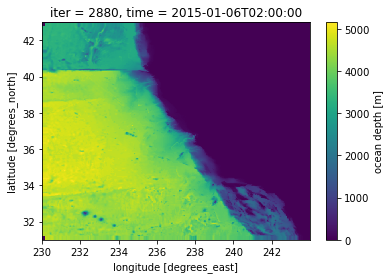

In [11]:
DEPTH = state_ds.Depth
DEPTH.plot()

## Interpolate the N2 vector onto a uniform pressure grid

In [12]:
N2_vector = Nsquared[:, laty, lonx]
Pmid_vector = Pressure_mid[:, laty, lonx]
#Pmid_vector, N2_vector
for i in range(len(N2_vector)-1):
    if N2_vector[i] < 0:
        N2_vector[i] = N2_vector[i+1] #np.median(np.absolute(N2_vector))
    if N2_vector[i] == 0:
        N2_vector[i] = N2_vector[i+1] #np.median(np.absolute(N2_vector))

In [13]:
Pmid_uniform = np.arange(Pmid_vector[0], Pmid_vector[-1], step = 120)
N2_uniform = np.interp(Pmid_uniform, Pmid_vector[:-2], N2_vector[:-2])

In [14]:
Pmid_uniform = Pmid_uniform[:]
N2_uniform = N2_uniform[:]
#Pmid_uniform[:-16], N2_uniform[:-16]

In [15]:
import VERT_FSFB3

In [16]:
c2, Psi, G, N2, Pmid = VERT_FSFB3.VERT_FSFB3(N2_uniform[:-16], Pmid_uniform[:-16])

In [17]:
g = 9.81 # gravity

## With a rigid lid assumpsion, SSH = Gm/g, where g is gravity, since hydrastatic pressure p = $rho * g *  SSH$

In [18]:
SSH = G/g

In [19]:
Z_mid_uniform  = gsw.z_from_p(np.append(0,Pmid), lat = laty)

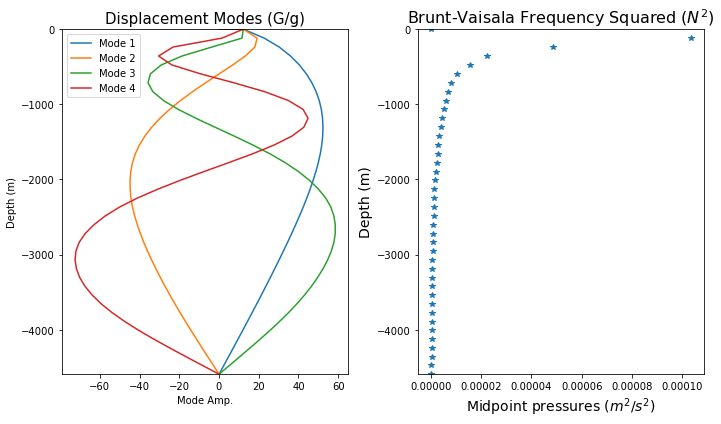

In [20]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(SSH[:,0], Z_mid_uniform, label = 'Mode 1')
plt.plot(SSH[:,1], Z_mid_uniform, label = 'Mode 2')
plt.plot(SSH[:,2], Z_mid_uniform, label = 'Mode 3')
plt.plot(SSH[:,3], Z_mid_uniform, label = 'Mode 4')
#plt.plot(SSH[:,4], Z_mid_uniform, label = 'Mode 5')
plt.xlabel('Mode Amp.')
plt.ylabel('Depth (m)')
#plt.xlim([-.2, .2])
plt.ylim([Z_mid_uniform.min(), 0])
plt.legend()
plt.title('Displacement Modes (G/g)', fontsize = 15)

plt.subplot(122)
plt.title('Brunt-Vaisala Frequency Squared ($N^2$)', fontsize = 16)
plt.plot(N2, Z_mid_uniform[1:], '*')
#plt.plot(Pmid_vector[:], N2_vector,  linewidth  = 2.0)
plt.xlabel('Midpoint pressures (${m^2}/{s^2}$)', fontsize = 14)
plt.ylabel('Depth (m)', fontsize = 14)
#plt.xlim([10, 350])
plt.ylim([Z_mid_uniform.min(), 0])

plt.tight_layout()
plt.savefig('vertical_modes_N2_sample_CCS_lon_' + str(lonx) + '_lat_' + str(laty) +'.png')

In [21]:
MODE = G.shape[-1]

In [22]:
Zgrid, mode = np.meshgrid(Z_mid_uniform, range(MODE) )

/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_83721/53837551.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(mode, Zgrid, SSH[:].T, cmap = cmo.cm.balance)
/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_83721/53837551.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(mode, Zgrid,G[:].T, cmap = cmo.cm.curl)
/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_83721/53837551.py:25: MatplotlibDeprec

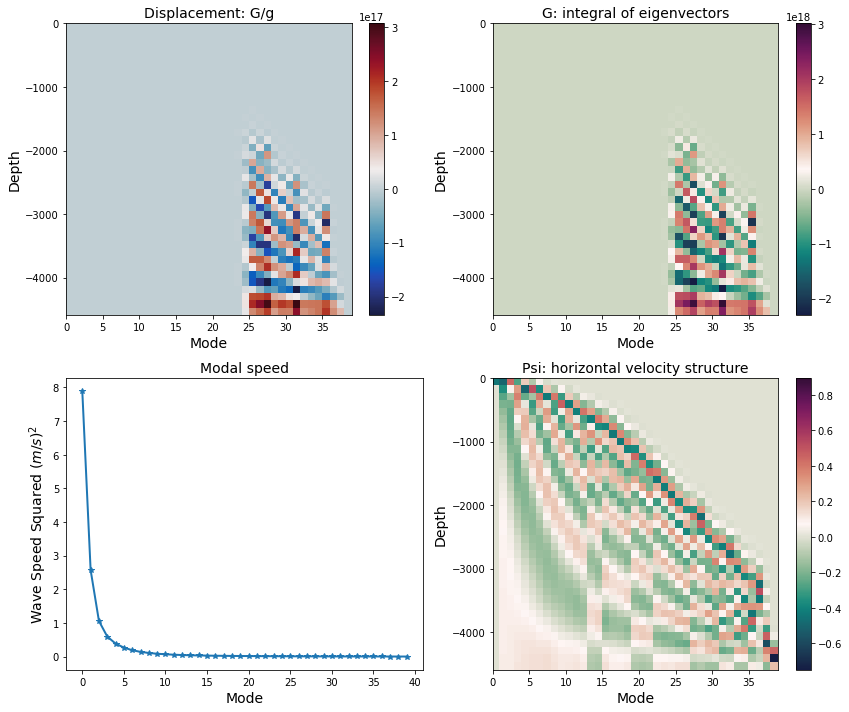

In [23]:
plt.figure(figsize = (12, 10))
plt.subplot(221)
plt.title('Displacement: G/g', fontsize = 14)
plt.pcolormesh(mode, Zgrid, SSH[:].T, cmap = cmo.cm.balance)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.subplot(222)
plt.title('G: integral of eigenvectors', fontsize = 14)
plt.pcolor(mode, Zgrid,G[:].T, cmap = cmo.cm.curl)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.subplot(223)
plt.title('Modal speed' , fontsize = 14)
plt.plot(c2[:], "-*", linewidth = 2)
plt.ylabel('Wave Speed Squared $(m/s)^2$', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
#plt.colorbar()

plt.subplot(224)
plt.title('Psi: horizontal velocity structure' , fontsize = 14)
plt.pcolor(mode, Zgrid, Psi[:].T, cmap = cmo.cm.curl)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.tight_layout()
plt.savefig('vertical_modes_FSFB2_N2_sample_lon_' + str(lonx) + '_lat_' + str(laty) +'.png', dpi = 100)

### Beta plane paramters

In [24]:
# wavespeed = # -c2[0]
Phi0 = 30 # central latitude (φ0)
Omega = 7.2921159e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N
# Gradient of Coriolis parameter f = f0 + beta * (y-y0) 
# The constant β (the Rossby parameter) is given its value at a central latitude (φ0) on the spherical earth, 
# (2Ω cosφ0)/a, where Ω is the angular speed of the earth and a its mean radius. 
Beta

3.53106090197239e-12

## Choose a wave with 200-km wavelength that moves westward (negative wave speed). 

In [25]:
wavelength = 2e5 # 200km
wavespeed = c2 # m/s 
#np.sqrt(wavespeed) #,c2

## The dispersion relation relates frequency to wavenumber for each mode:

In [26]:
k_n = 2 * np.pi / wavelength # wavenumber
k_n

3.141592653589793e-05

## Rossby deformation radius Rm = c/f0 = 50.6 km, consistent with Chelton et al. (1998) https://ceoas.oregonstate.edu/rossby_radius

In [27]:
Rm = wavespeed / f0
Rm[0]/1000, f0

(-54.73026096765938, -0.00014409682231500762)

## SSH Five Baroclinic mode, N=1 in ln, kn, w_n

### Amplitude matrix

In [28]:
Amp = np.array([[1.5, 1.7, .5], [1.6, 1., .3]])
M = Amp.size
M, Amp.shape

(6, (2, 3))

In [29]:
wavelength_l = 0.4 * wavelength
l_n = 2 * np.pi / wavelength_l # wavenumber
l_n, k_n, wavelength, wavelength_l

(7.853981633974483e-05, 3.141592653589793e-05, 200000.0, 80000.0)

### Expand SSH to 2-dimensional space - SSH(x, y, t)

In [30]:
Rm = wavespeed / f0
Rm[:int(M/2)]/1000, f0

(array([-54.73026097, -17.84791968,  -7.33631201]), -0.00014409682231500762)

In [31]:
freq_n = (Beta * k_n) / (k_n ** 2 + l_n ** 2 + Rm[:int(M/2)] ** (-2))
freq_n

array([1.48119888e-08, 1.07755927e-08, 4.31046405e-09])

In [32]:
X_loc = np.arange(0, 1e6, 1e4)
Y_loc = np.arange(0, 1e6, 1e4)
T_time = np.arange(0, 1e8, 1e6)

### Elements of H Matrix

In [33]:
%%time
H_cos = np.ma.masked_all([len(T_time), len(X_loc), len(Y_loc), Amp.shape[1]]) # Number of waves * Number of data
H_sin = np.ma.masked_all([len(T_time), len(X_loc), len(Y_loc), Amp.shape[1]])
for mm in range(Amp.shape[1]):
    for tt in range(len(T_time)):
        for xx in range(len(X_loc)):
            for yy in range(len(Y_loc)):
                H_cos[tt, xx, yy, mm] = Psi[0, mm] * np.cos(k_n * X_loc[xx] + l_n * Y_loc[yy] + freq_n[mm] * T_time[tt]) 
                H_sin[tt, xx, yy, mm] = Psi[0, mm] * np.sin(k_n * X_loc[xx] + l_n * Y_loc[yy] + freq_n[mm] * T_time[tt])

CPU times: user 15.5 s, sys: 135 ms, total: 15.6 s
Wall time: 15.7 s


In [34]:
SSH_XYTM_1 = np.ma.masked_all([len(T_time), len(X_loc), len(Y_loc), Amp.shape[1]])
for mm in range(Amp.shape[1]):
    print(mm)
    SSH_XYTM_1[:, :, :, mm] = Amp[0, mm] * H_cos[:, :, :, mm] + Amp[1, mm] * H_sin[:, :, :, mm]

0
1
2


#### Test whether we can use H_sin and H_cos to produce SSH

In [35]:
SSH_XYTM = np.ma.masked_all([len(T_time), len(X_loc), len(Y_loc), Amp.shape[1]])
for mm in range(Amp.shape[1]):
    for tt in range(len(T_time)):
        for xx in range(len(X_loc)):
            for yy in range(len(Y_loc)):
                SSH_XYTM[tt, xx, yy, mm] = Amp[0, mm] * Psi[0, mm] * np.cos(k_n * X_loc[xx] + l_n * Y_loc[yy] + freq_n[mm] * T_time[tt]) + Amp[1, mm] * Psi[0, mm] * np.sin(k_n * X_loc[xx] + l_n * Y_loc[yy] + freq_n[mm] * T_time[tt])

#### Add up long the last two axis: modes, frequences

In [36]:
SSH_XYT = np.sum(SSH_XYTM, axis = -1)

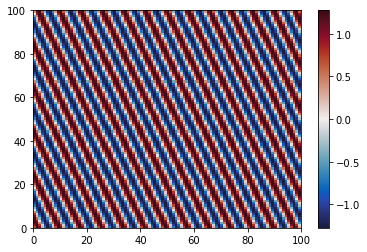

In [37]:
plt.pcolor(SSH_XYT[0], cmap = cmo.cm.balance)
plt.colorbar()

### Select y samples

In [38]:
tindex = np.random.randint(low = 0, high= 99, size= 6)
yindex = np.random.randint(low = 0, high= 99, size= 6) #np.array([4, 32, 61, 86, 92, 99])
xindex = np.random.randint(low = 0, high= 99, size= 6) #np.array([15, 20, 30, 40, 55, 60]) 
tindex, xindex, yindex

(array([64, 31, 92, 96, 89, 30]),
 array([ 7, 54, 20,  8, 63,  0]),
 array([38, 16, 16, 68, 92,  5]))

In [39]:
y_m = SSH_XYT[tindex, xindex, yindex].data
y_m

array([ 0.96426355, -0.90685364,  1.04380705,  1.16441497, -0.23484048,
       -1.2062245 ])

In [40]:
M, N = Amp.size, y_m.size
M, N

(6, 6)

In [41]:
H_ = np.ma.masked_all([len(T_time), len(X_loc), len(Y_loc), M])
H_[:, :, :, 0::2], H_[:, :, :, 1::2] = H_cos, H_sin

In [42]:
# Convert the T, X, Y space to 1-dimensional space
IIndex = np.zeros(N) # N: Number of y data
Y_v = np.zeros(N) 
H_v = np.zeros([N, M]) # M: number of model
nx, ny = N, N
for iii in range(N):
    print(iii, tindex[iii], xindex[iii], yindex[iii])
    IIndex[iii] = nx * ny * tindex[iii] + ny * xindex[iii] + yindex[iii]
    Y_v[iii] = SSH_XYT[tindex[iii], xindex[iii], yindex[iii]]
    H_v[iii, :] = H_[tindex[iii], xindex[iii], yindex[iii], :]

0 64 7 38
1 31 54 16
2 92 20 16
3 96 8 68
4 89 63 92
5 30 0 5


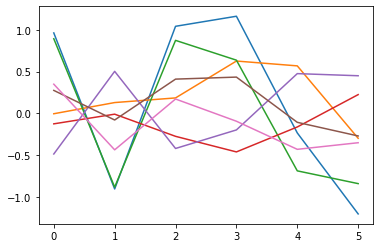

In [43]:
plt.plot(Y_v)
plt.plot(H_v)

#### Ordinary Least Squares (OLS) Solution
#### The solution is $X_{OLS} = (H^TH)^{-1}H^Ty$
#### Solution: Amp = np.array([[1, .7, .5], [.6, .4, .3]])

In [44]:
H_inv = LA.inv(np.matmul(H_v.T, H_v))

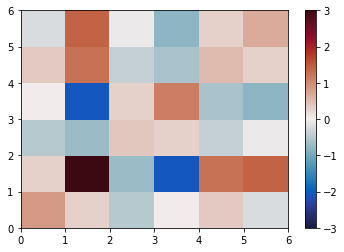

In [45]:
plt.pcolor(np.matmul(H_v.T, H_v), vmin = -3, vmax = 3, cmap = cmo.cm.balance)
plt.colorbar()

In [46]:
eig, vec = LA.eig(np.matmul(H_v.T, H_v))
eig.real

array([6.08922788e+00, 1.34795692e+00, 6.41071477e-02, 7.29626333e-03,
       7.60882274e-07, 2.14738621e-05])

In [47]:
X_OLS = np.matmul(np.matmul(H_inv, H_v.T), Y_v)

In [48]:
Amp = np.array([[1.5, 1.7, .5], [1.6, 1., .3]])
Amp

array([[1.5, 1.7, 0.5],
       [1.6, 1. , 0.3]])

In [49]:
X_OLS.reshape([2, 3], order = 'F')

array([[1.5, 1.7, 0.5],
       [1.6, 1. , 0.3]])

### Weighted least square solution

In [50]:
num_samples = len(Y_loc)
noise_std = .7

In [51]:
SSH_WN = np.ma.masked_all(SSH_XYT.shape)
white_noise_x, white_noise_y = np.ma.masked_all(SSH_XYT.shape), np.ma.masked_all(SSH_XYT.shape)
for tt in range(len(T_time)):
    for yy in range(len(Y_loc)):
        white_noise_y[tt, yy] = np.random.normal(0, noise_std, size = num_samples)
        SSH_WN[tt, yy] = SSH_XYT[tt, yy]  + white_noise_y[tt, yy]

In [52]:
Y_WN = SSH_WN[tindex, xindex, yindex].data
Y_WN, tindex, xindex, yindex

(array([ 2.24960005, -1.27981247,  0.23631377,  0.27292126,  2.38090809,
        -0.62959103]),
 array([64, 31, 92, 96, 89, 30]),
 array([ 7, 54, 20,  8, 63,  0]),
 array([38, 16, 16, 68, 92,  5]))

In [53]:
SSH_WN.shape

(100, 100, 100)

In [54]:
# Convert the T, X, Y space to 1-dimensional space
IIndex = np.zeros(N) # N: Number of y data
Y_v_WN = np.zeros(N) 
H_v = np.zeros([N, M]) # M: number of model
nx, ny = N, N
for iii in range(N):
    IIndex[iii] = nx * ny * tindex[iii] + ny * xindex[iii] + xindex[iii]
    Y_v_WN[iii] = SSH_XYT[tindex[iii], xindex[iii], yindex[iii]]
    H_v[iii, :] = H_[tindex[iii], xindex[iii], yindex[iii], :]
    print(iii, SSH_WN[tindex[iii], xindex[iii], yindex[iii]])

0 2.2496000462005603
1 -1.2798124664750836
2 0.23631377016446042
3 0.27292125670381284
4 2.3809080879386184
5 -0.6295910299096724


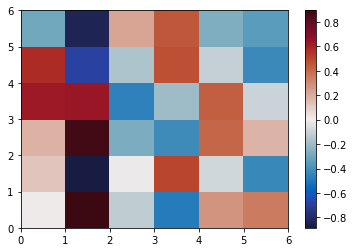

In [55]:
plt.pcolor(H_v, cmap = cmo.cm.balance)
plt.colorbar()

In [73]:
H_v

array([[-0.00490965,  0.89436466, -0.1259818 , -0.48760388,  0.27506296,
         0.34962013],
       [ 0.12924183, -0.88499084, -0.01001329,  0.50351633, -0.07987587,
        -0.4376228 ],
       [ 0.18477384,  0.87508335, -0.27575837, -0.42140987,  0.41032945,
         0.17182437],
       [ 0.62719196,  0.63760684, -0.46264838, -0.1989609 ,  0.4346566 ,
        -0.09469693],
       [ 0.56926939, -0.6898149 , -0.16353108,  0.4763261 , -0.10776683,
        -0.43160188],
       [-0.29913904, -0.84286895,  0.22454018,  0.45078894, -0.27136845,
        -0.35249544]])

In [56]:
residual = Y_v_WN.std() # = n * sigma **2

In [57]:
residual

0.9656079465531144

#### R Matrix

In [58]:
R_ = np.eye(N, N)

In [59]:
for ii in range(N):
    R_[ii, ii] = (residual * 0.7) ** 2 #. half of the variance is noise
R_

array([[0.45687537, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.45687537, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.45687537, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.45687537, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.45687537,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.45687537]])

#### P matrix =0 For now

In [60]:
A = np.matmul(H_v.T, LA.inv(R_))

In [61]:
HRH = np.matmul(A, H_v)

In [62]:
D = np.matmul(np.matmul(LA.inv(HRH), H_v.T) , LA.inv(R_))

In [63]:
eig, vec = LA.eig(HRH)
eig.real

array([1.33279847e+01, 2.95038214e+00, 1.40316490e-01, 1.59699206e-02,
       1.66540446e-06, 4.70015756e-05])

#### Soution with noise

In [64]:
X_ = np.matmul(D, Y_v_WN)

In [65]:
X_.reshape([2, 3], order = 'F')

array([[1.5, 1.7, 0.5],
       [1.6, 1. , 0.3]])

In [66]:
Y_v

array([ 0.96426355, -0.90685364,  1.04380705,  1.16441497, -0.23484048,
       -1.2062245 ])

In [67]:
np.matmul(H_v, X_)

array([ 0.96426355, -0.90685364,  1.04380705,  1.16441497, -0.23484048,
       -1.2062245 ])

#### Solution with no noise

In [68]:
C = np.matmul(H_v.T, H_v) # No noise setup
eig, vec = LA.eig(C)
eig.real

array([6.08922788e+00, 1.34795692e+00, 6.41071477e-02, 7.29626333e-03,
       7.60882274e-07, 2.14738621e-05])

In [69]:
X_no_noise = np.matmul(np.matmul(LA.inv(C) , H_v.T) , Y_v) # assume no noise

In [70]:
X_no_noise.reshape([2, 3], order = 'F')

array([[1.5, 1.7, 0.5],
       [1.6, 1. , 0.3]])

In [71]:
eig_values, eig_vector = LA.eig(np.matmul(H_v.T, H_v))

In [72]:
eig_values.real

array([6.08922788e+00, 1.34795692e+00, 6.41071477e-02, 7.29626333e-03,
       7.60882274e-07, 2.14738621e-05])